## Objective for this Notebook
1. Learn how to use a Convolutional Neural Network to classify handwritten digits from the MNIST database
2. Learn how to reshape the images to make them faster to process

## Preparation

In [1]:
# Import the libraries we need to use in this lab
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the function for plotting the channels
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0

    #plot outputs as rows inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [3]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)
    plt.show()

In [4]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [15]:
def show_data(data_sample):
  plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
  plt.title('y = ' + str(data_sample[1]))

## Get the Data

In [6]:
IMAGE_SIZE = 16

In [8]:
composed = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

In [9]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.86MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [11]:
# Show the data type for each element in dataset
type(train_dataset[0][1])

int

In [12]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078,
           0.0196, 0.0824, 0.1059, 0.0980, 0.1843, 0.0902, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0039, 0.0824, 0.2157, 0.3765, 0.5333,
           0.6118, 0.7373, 0.6627, 0.6196, 0.7647, 0.3020, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0118, 0.3804, 0.8549, 0.9294, 0.9569,
           0.8784, 0.9294, 0.4588, 0.2510, 0.2000, 0.0510, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.1569, 0.4588, 0.7765, 0.7608,
           0.2353, 0.3137, 0.1412, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0078, 0.4275, 0.6941,
           0.1137, 

In [13]:
# The label for the fourth data element
train_dataset[3][1]

1

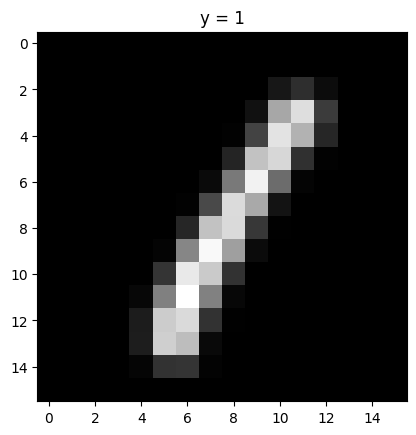

In [16]:
show_data(train_dataset[3])

## Build a Convolutional Neural Network Class

In [20]:
class CNN(nn.Module):

  # Constructor
  def __init__(self, out_1=16, out_2=32):
    super(CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(out_2*4*4, 10)

  # Prediction
  def forward(self, x):
    x = self.cnn1(x)
    x = torch.relu(x)
    x = self.maxpool1(x)
    x = self.cnn2(x)
    x = torch.relu(x)
    x = self.maxpool2(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    return x

  # output in each step
  def activations(self, x):
    z1 = self.cnn1(x)
    a1 = torch.relu(z1)
    out = self.maxpool1(a1)

    z2 = self.cnn2(out)
    a2 = torch.relu(z2)
    out1 = self.maxpool2(a2)

    out = out.view(out.size(0), -1)
    return z1, a1, z2, a2, out1, out

## Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model

In [21]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

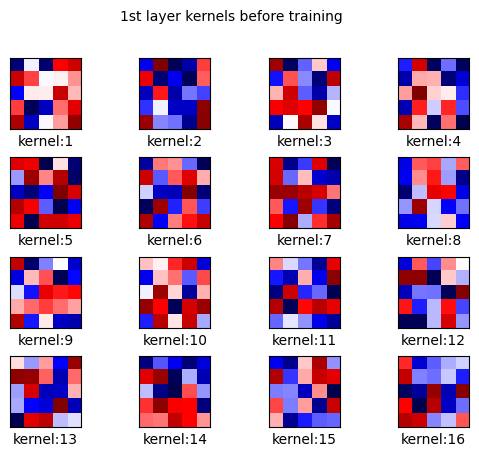

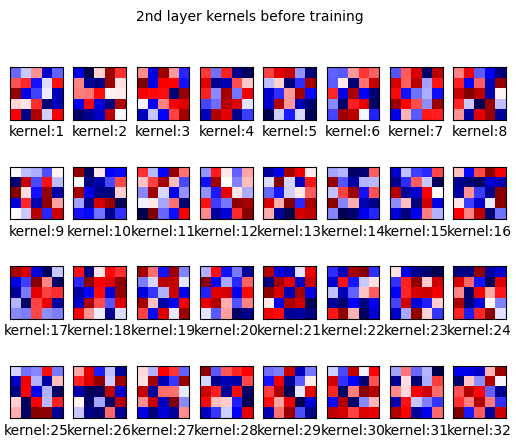

In [22]:
# Plot the parameters
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name="2nd layer kernels before training")

In [24]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [25]:
# Train the model
n_epochs = 3
cost_list = []
accuracy_list = []
N_test = len(validation_dataset)
COST = 0

def train_model(n_epochs):
  for epoch in range(n_epochs):
    COST = 0
    for x, y in train_loader:
      optimizer.zero_grad()
      z = model(x)
      loss = criterion(z, y)
      loss.backward()
      optimizer.step()
      COST += loss.data

    cost_list.append(COST)
    correct = 0

    for x_test, y_test in validation_loader:
      z = model(x_test)
      _,label = torch.max(z.data, 1)
      correct += (label == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
train_model(n_epochs)

## Analyze Results

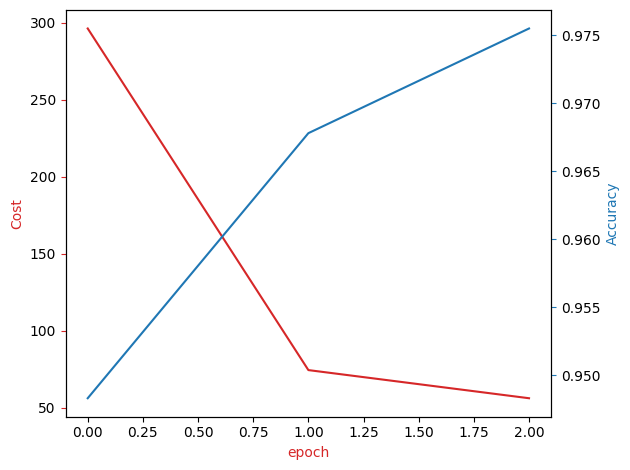

In [28]:
# Plot the loss and accuracy
fig, ax1 = plt.subplots()
color='tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color='tab:blue'
ax2.set_xlabel('epoch', color=color)
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

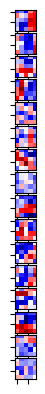

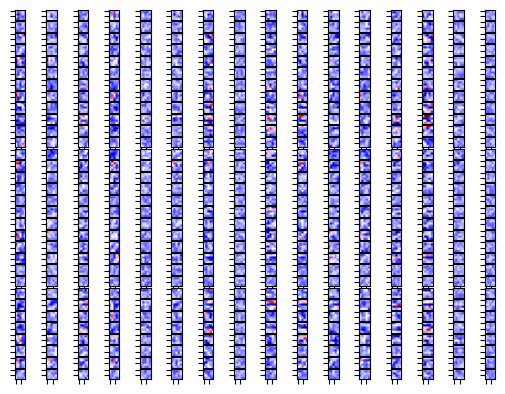

In [29]:
# Plot the channels
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

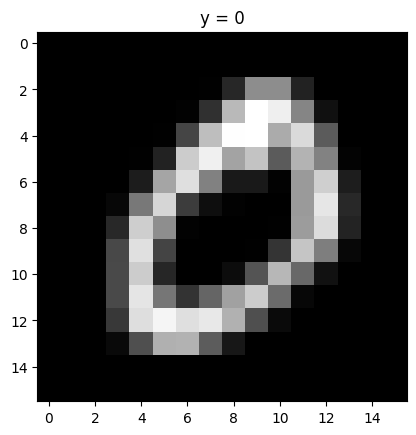

In [30]:
# Show the second image
show_data(train_dataset[1])

In [31]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

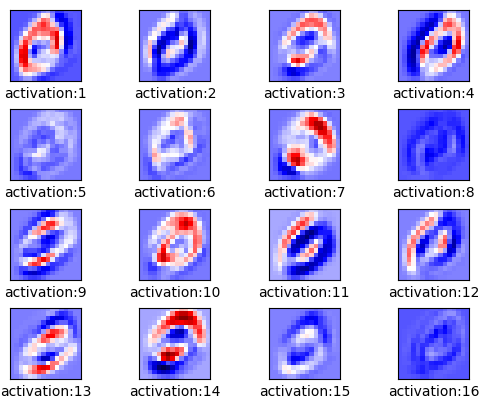

In [32]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after first CNN")

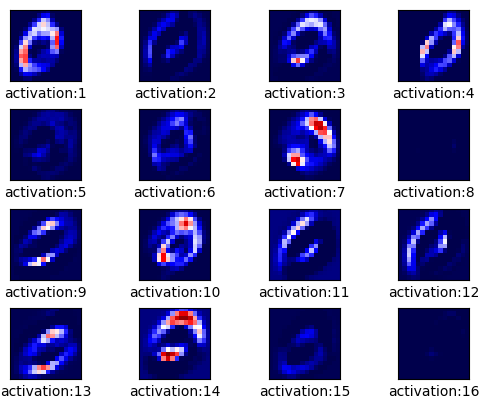

In [33]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the first ReLU")

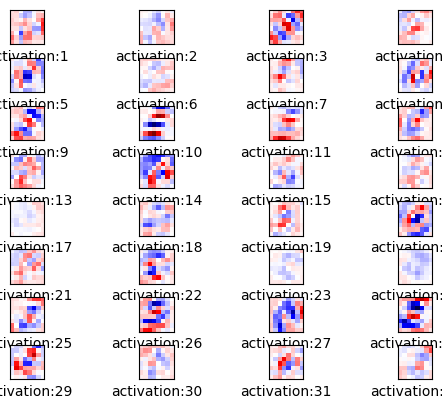

In [34]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32//4, name="Output after second CNN")

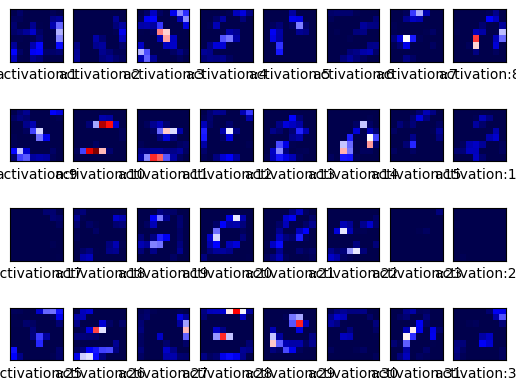

In [35]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after second ReLU")

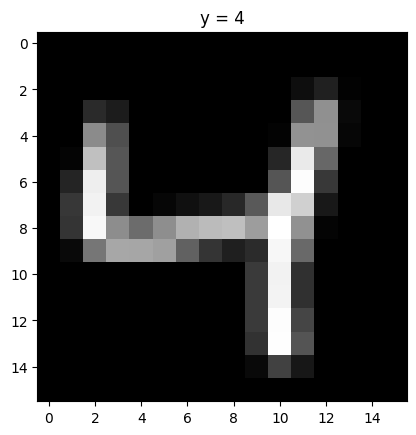

In [36]:
# Show the third image
show_data(train_dataset[2])

In [37]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[2][0].view(1,1,IMAGE_SIZE, IMAGE_SIZE))

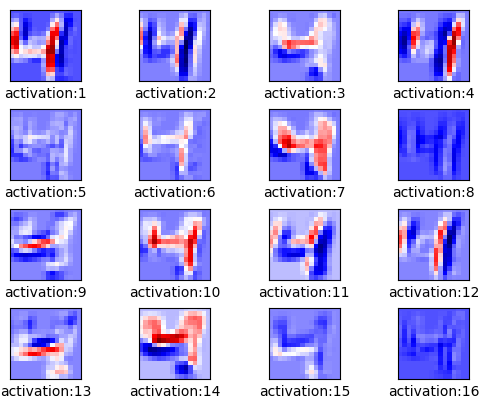

In [38]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after first CNN")

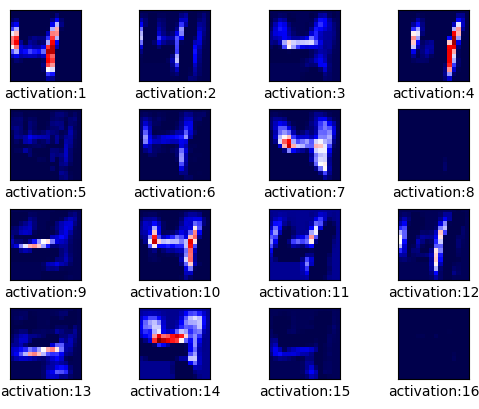

In [39]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after first ReLU")

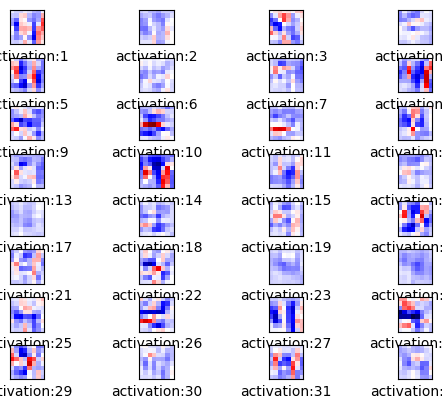

In [40]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32//4, name="Output after secon CNN")

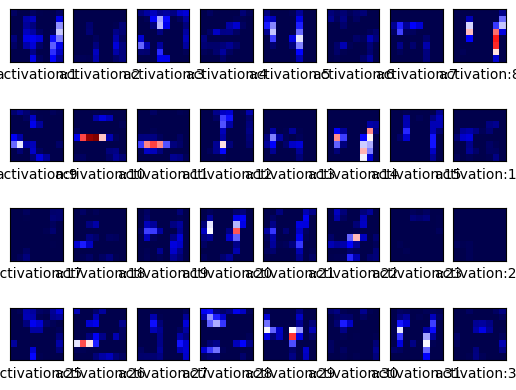

In [42]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after second ReLU")

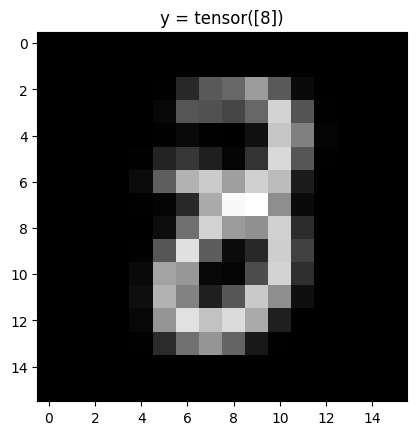

yhat:  tensor([3])


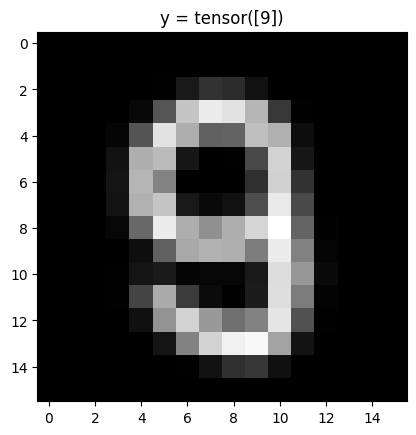

yhat:  tensor([8])


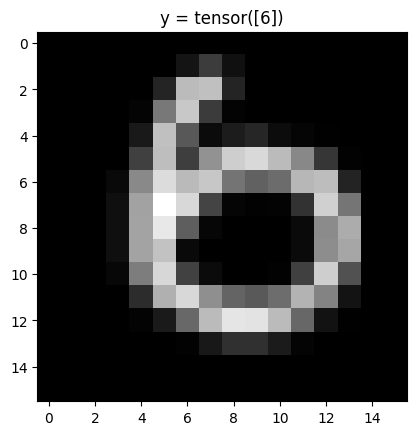

yhat:  tensor([0])


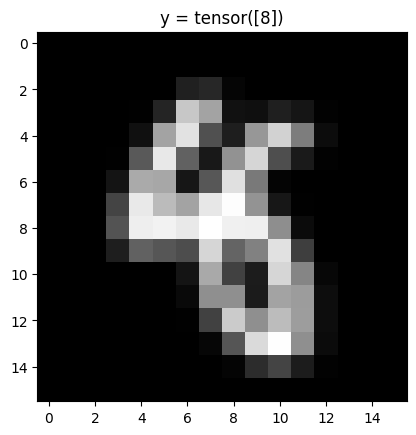

yhat:  tensor([4])


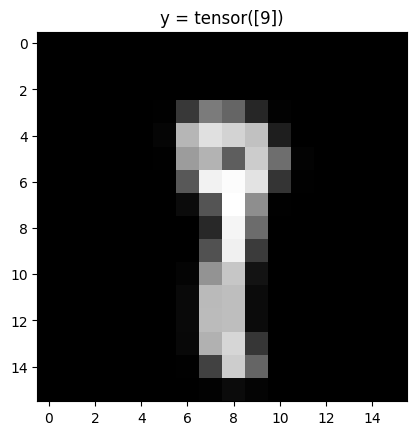

yhat:  tensor([1])


In [44]:
# Plot the mis-classified samples
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
  z = model(x)
  _,label= torch.max(z, 1)
  if label != y:
    show_data((x, y))
    plt.show()
    print("yhat: ", label)
    count += 1
  if count >= 5:
    break